In [1]:
install.packages("remotes")
install.packages("tidyverse")
install.packages("RAthena")
install.packages("glue")
install.packages('bit64')       # Esto es para mostrar correctamente columnas en Athena que tengan tipo int64
install.packages('devtools')
install.packages('leaflet')
install.packages('htmlwidgets') # Para poder mostrar la salida de leaflet dentro del notebook Jupyter
install.packages('lubridate')


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependency ‘bit’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘credentials’, ‘zip’, ‘gitcreds’, ‘ini’, ‘gert’, ‘gh’, ‘whisker’, ‘rex’, ‘crosstalk’, ‘xopen’, ‘brew’, ‘usethis’, ‘covr’, ‘DT’, ‘memoise’, ‘rcmdcheck’, ‘roxygen2’, ‘rversions’, ‘sessioninfo’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘gridExtra’, ‘png’, ‘raster’, ‘sp’, ‘viridis’, ‘leaflet.providers’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.ht

In [2]:
#La instalación de sf requiere dependencias delicadas como libunits y gdal. Con conda hubo suerte y se instala sin lío
system('conda install -c conda-forge -y r-sf')

#Para instalar H3 en R, el camino fue V8 +  crazycapivara/h3forr + geojsonio
system('conda install -c conda-forge -y r-v8 ')
system('conda install -c conda-forge -y r-geojsonio')
remotes::install_github("crazycapivara/h3forr")

utf8 (1.1.4 -> 1.2.1) [CRAN]


Installing 1 packages: utf8

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



✔  checking for file ‘/tmp/Rtmpzi09nv/remotes2051505a8e6/crazycapivara-h3forr-5c74feb/DESCRIPTION’
─  preparing ‘h3forr’:
✔  checking DESCRIPTION meta-information
─  excluding invalid files
   Subdirectory 'R' contains invalid file names:
     ‘_custom_buffer_points.R’
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Removed empty directory ‘h3forr/javascript’
   Removed empty directory ‘h3forr/sandbox’
─  building ‘h3forr_0.1.4.9000.tar.gz’
   


In [3]:
library(tidyverse)
library(sf)
library(DBI)
library(glue)
library(h3forr)
library(leaflet)
library(htmlwidgets)
library(lubridate)


Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“It is strongly recommended to set envionment variable TZ to ‘Etc/UCT’ (or equivalent)”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Linking to GEOS 3.9.1, GDAL 3.2.2, PROJ 8.0.0


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse



Attaching package: ‘h3forr’


The following object is masked from ‘package:purrr’:

    compact



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [4]:
s3_staging = 's3://iadbprod-csd-hub-analyticaldata/graphdata-mobility-temporal/athena-results/'
region = 'us-east-1'
schema = 'graphdata'

In [5]:
place_name <- 'peru_departamento_lima'

# Tabla con matriz Origen Destino
OD_table <- glue('{place_name}_OD_matrix')

# Tabla con celdas de residencia y de ocupación de usuarios

locations_table <- glue('{place_name}_user_locations')

In [6]:
con <- dbConnect(RAthena::athena(),
                 s3_staging_dir = s3_staging,
                 region_name = region,
                 schema_name = schema)

In [7]:
OD <- tbl(con, OD_table)

locations <- tbl(con, locations_table)

pings <-  tbl(con, glue('{place_name}_pings'))



## Análisis de sitio de interés

In [8]:
sitio <- read_sf("https://bitsandbricks.github.io/data/mesa_redonda.geojson")

Identificamos las celdas H3 del sitio:

In [10]:
h3_res <- 9

In [11]:
# Definimos un buffer de unos metros (en centesimas de grados lat/lon en este caso) en torno al sitio de interés, para
# asegurarnos de obtner las celdas que lo pisan aun cuando su centro no este dentro del polígono

grilla_sitio <- cbind(h3idx = polyfill(st_sf(st_buffer(st_union(sitio), 0.0015)), res = h3_res),
                      geo_boundary_to_sf(h3_to_geo_boundary(polyfill(st_sf(st_buffer(st_union(sitio), 0.0015)), res = h3_res))))

head(grilla_sitio)

although coordinates are longitude/latitude, st_union assumes that they are planar

Warning message in st_buffer.sfc(st_union(sitio), 0.0015):
“st_buffer does not correctly buffer longitude/latitude data”
dist is assumed to be in decimal degrees (arc_degrees).

although coordinates are longitude/latitude, st_union assumes that they are planar

Warning message in st_buffer.sfc(st_union(sitio), 0.0015):
“st_buffer does not correctly buffer longitude/latitude data”
dist is assumed to be in decimal degrees (arc_degrees).

Warning message in fun(libname, pkgname):
“rgeos: versions of GEOS runtime 3.9.1-CAPI-1.14.2
and GEOS at installation 3.9.1dev-CAPI-1.14.1differ”
Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,h3idx,geometry
,<chr>,<POLYGON [°]>
1,898e62c2b03ffff,POLYGON ((-77.01299 -12.045...
2,898e62c2b7bffff,POLYGON ((-77.01963 -12.051...
3,898e62c0cafffff,POLYGON ((-77.02627 -12.058...
4,898e62c2b6bffff,POLYGON ((-77.01996 -12.055...
5,898e62c2b5bffff,POLYGON ((-77.02496 -12.044...
6,898e62c0c17ffff,POLYGON ((-77.03193 -12.054...


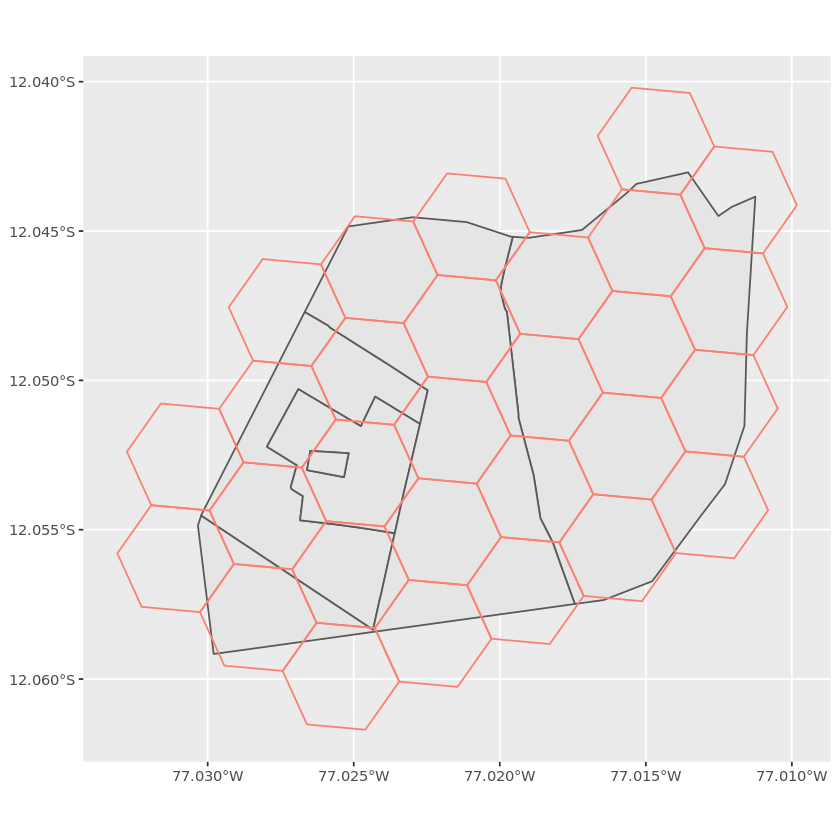

In [12]:
ggplot() + geom_sf(data = sitio) + geom_sf(data = grilla_sitio, fill = NA, color = "salmon")

Obtenemos la geometría de las celdas presentes en la tabla OD

In [13]:
idx_h3_area_total <- OD %>% filter(!is.na(h3idx)) %>% distinct(h3idx) %>% pull(h3idx)

Info: (Data scanned: 110.67 MB)



In [14]:
head(idx_h3_area_total)

[1] "898e62c131bffff" "898e62c2e0fffff" "898e75a4eb3ffff" "898e621a083ffff"
[5] "898e621a437ffff" "898e628367bffff"

In [15]:
grilla_area_total <- cbind(h3idx = idx_h3_area_total,
                           geo_boundary_to_sf(h3_to_geo_boundary(idx_h3_area_total)))


En contexto:

In [ ]:
leaflet(height = 700) %>% 
    addTiles() %>% 
    #addPolygons(data = grilla_area_total), fillOpacity = 0) %>% 
    addPolygons(data = sitio, color = "purple") %>%
    addPolygons(data = grilla_sitio, color = "orange", fillOpacity = 0)

Parece que no hay manera de visualizar mejor la salida de leaflet en R via Jupyer

Lo que podemos hacer es guardar el output como HTML autocontenido y mostrarlo en como iframe desde un notebook python.

Por ejemplo con:

```
from IPython.display import IFrame
IFrame(src='map.html', width="100%", height=800)
```

In [ ]:
# El output puede verse en un notebook Python via 
# from IPython.display import IFrame
# IFrame(src='map.html', width="100%", height=800)

m <- leaflet(height = 700) %>% 
    addTiles() %>% 
    addPolygons(data = grilla_area_total, fillOpacity = 0) %>% 
    addPolygons(data = sitio, color = "purple") %>%
    addPolygons(data = grilla_sitio, color = "orange", fillOpacity = 0)


saveWidget(widget = m, file = "/home/ec2-user/SageMaker/Fase3/Matriz OD/map.html")

## Distribucion de residencia y trabajo

Tomamos 

- sólo identificaciones de hogar u ocupación que hayan registrado más de 10 pings - __umbral a revisar, solo un comienzo__
- solo celdas cuyo conteo de usuarios residentes supere los 15 (para preservar privacidad)

In [16]:
totales_home <- locations %>% 
    group_by(h3idx_home) %>% 
    summarise(total_home = n()) %>% 
    filter(total_home > 15) %>% 
    rename(h3idx = h3idx_home) %>%
    collect()

totales_occupation <- locations %>% 
    group_by(h3idx_occupation) %>% 
    summarise(total_occupation = n()) %>% 
    rename(h3idx = h3idx_occupation) %>%
    collect()

Info: (Data scanned: 302.08 KB)

Info: (Data scanned: 294.57 KB)



In [17]:
totales_location <- totales_home %>% full_join(totales_occupation)

Joining, by = "h3idx"



In [18]:
head(totales_location)

h3idx,total_home,total_occupation
<chr>,<int64>,<int64>
898e62d486bffff,30,17
898e62c528bffff,31,27
898e62c736bffff,17,10
898e62c0e1bffff,26,20
898e62c0833ffff,37,50
898e62c2683ffff,23,9


In [19]:
grilla_area_total <- grilla_area_total %>% left_join(totales_location)

Joining, by = "h3idx"



In [20]:
pal_deciles <- colorNumeric(palette = "plasma", domain = 1:10)

In [21]:
grilla_area_total <- grilla_area_total %>% mutate(decil_hogar = ntile(total_home, 10),
                             decil_ocupacion = ntile(total_home, 10)) 

In [ ]:
mapa_densidad_hogares <- grilla_area_total %>% 
    group_by(decil_hogar) %>%
    summarise(decil = last(decil_hogar)) %>%
    leaflet(height = 700) %>% 
    addProviderTiles(provider = providers$CartoDB.Positron) %>% 
    addPolygons(color = ~ pal_deciles(decil)) %>%
    addLegend("bottomleft", 
              pal = pal_deciles, 
              values = 1:10,
              title = "densidad\n(hogares)",
              opacity = 1)
    

In [ ]:
saveWidget(widget = mapa_densidad_hogares, file = "/home/ec2-user/SageMaker/Fase3/Matriz OD/mapa_densidad_hogares.html")

In [ ]:
mapa_densidad_ocupacion <- grilla_area_total %>% 
    group_by(decil_ocupacion) %>%
    summarise(decil = last(decil_ocupacion)) %>%
    leaflet(height = 700) %>% 
    addProviderTiles(provider = providers$CartoDB.Positron) %>% 
    addPolygons(color = ~ pal_deciles(decil)) %>%
    addLegend("bottomleft", 
              pal = pal_deciles, 
              values = 1:10,
              title = "actividad\ndiurna",
              opacity = 1)
    

In [ ]:
saveWidget(widget = mapa_densidad_ocupacion, file = "/home/ec2-user/SageMaker/Fase3/Matriz OD/mapa_densidad_ocupacion.html")

## Visitas al sitio de interes

In [22]:
visitas_sitio <- OD %>% 
    filter(h3idx %in% local(grilla_sitio$h3idx)) %>%
    collect()

Info: (Data scanned: 136.91 MB)



In [23]:
origenes_visitas <- visitas_sitio %>% 
    filter(!(h3idx_home %in% grilla_sitio$h3idx)) %>% 
    group_by(h3idx_home) %>% 
    summarise(visitantes = sum(n)) %>% 
    collect() %>%
    {left_join(grilla_area_total, ., by = c("h3idx" = "h3idx_home"))} 


In [49]:
pal <- colorNumeric(palette = "viridis", domain = origenes_visitas$n)

mapa_origen_visitas <- leaflet(filter(origenes_visitas, !is.na(visitantes))) %>%
    addMapPane(name = "polygons", zIndex = 410) %>% 
    addMapPane(name = "maplabels", zIndex = 420) %>% # higher zIndex rendered on top
    addProviderTiles("CartoDB.PositronNoLabels") %>%
    addProviderTiles("CartoDB.PositronOnlyLabels", 
                       options = leafletOptions(pane = "maplabels")) %>%
    addPolygons(color = ~pal(visitantes), fillOpacity = 1,stroke = FALSE,
                options = leafletOptions(pane = "polygons")) %>% 
    addPolygons(data = st_union(grilla_sitio), color = "red",
                options = leafletOptions(pane = "polygons")) %>% 
    addLegend("bottomright", pal = pal, values = ~visitantes,
    title = "visitantes<br>(origen)",
    opacity = 1)

saveWidget(widget = mapa_origen_visitas, file = "/home/ec2-user/SageMaker/Fase3/Matriz OD/mapa_origen_visitas.html")

although coordinates are longitude/latitude, st_union assumes that they are planar

Warning message in pretty.default(values, n = bins):
“Internal(pretty()): very small range.. corrected”


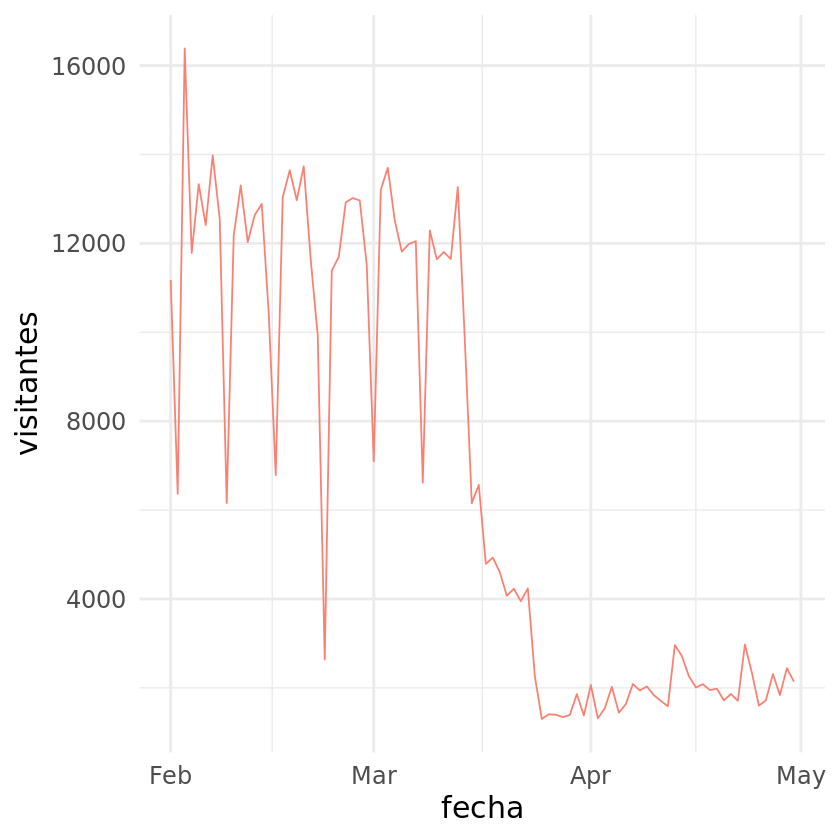

In [24]:
visitas_sitio %>%
    filter(!(h3idx_home %in% grilla_sitio$h3idx), month < 5) %>% 
    mutate(fecha = ymd(paste(year, month, day, sep = "-"))) %>% 
    group_by(fecha) %>% 
    summarise(visitantes = as.integer(sum(n))) %>% 
    ggplot() +
    geom_line(aes(x = fecha, y = visitantes), color = "salmon") +
    scale_x_date(date_breaks = "1 month", date_labels = "%b") +
    theme_minimal(base_size = 18)

`summarise()` has grouped output by 'year', 'month', 'day'. You can override using the `.groups` argument.



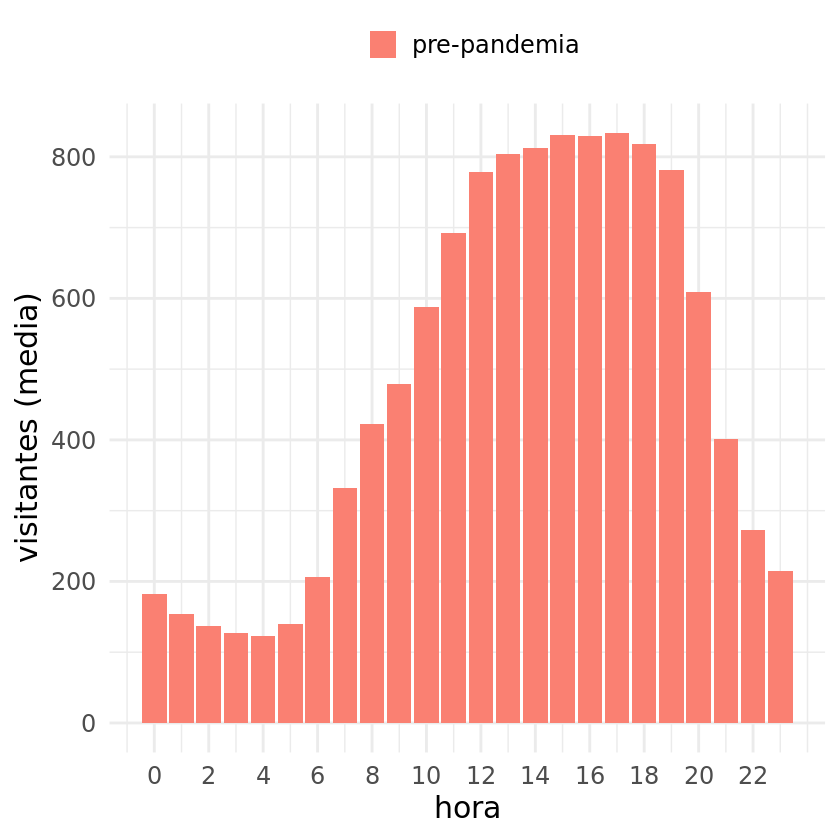

In [56]:
visitas_sitio %>%
    filter(!(h3idx_home %in% grilla_sitio$h3idx), month < 3) %>% 
    group_by(year, month, day, hour_of_day) %>% 
    summarise(visitantes = as.integer(sum(n))) %>% 
    group_by(hour_of_day) %>%
    summarise(media_visitantes = as.numeric(mean(visitantes)), 
              periodo = "pre-pandemia") %>%
    ggplot() +
    geom_col(aes(x = as.integer(hour_of_day), y = media_visitantes, fill = periodo)) +
    scale_x_continuous(breaks = seq(0, 23, by = 2)) +
    scale_fill_manual(values = c("pre-pandemia" = "salmon")) +
    labs(x = "hora", y = "visitantes (media)", fill = NULL) +
    theme_minimal(base_size = 18) +
    theme(legend.position = "top")

`summarise()` has grouped output by 'year', 'month', 'day'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'year', 'month', 'day'. You can override using the `.groups` argument.



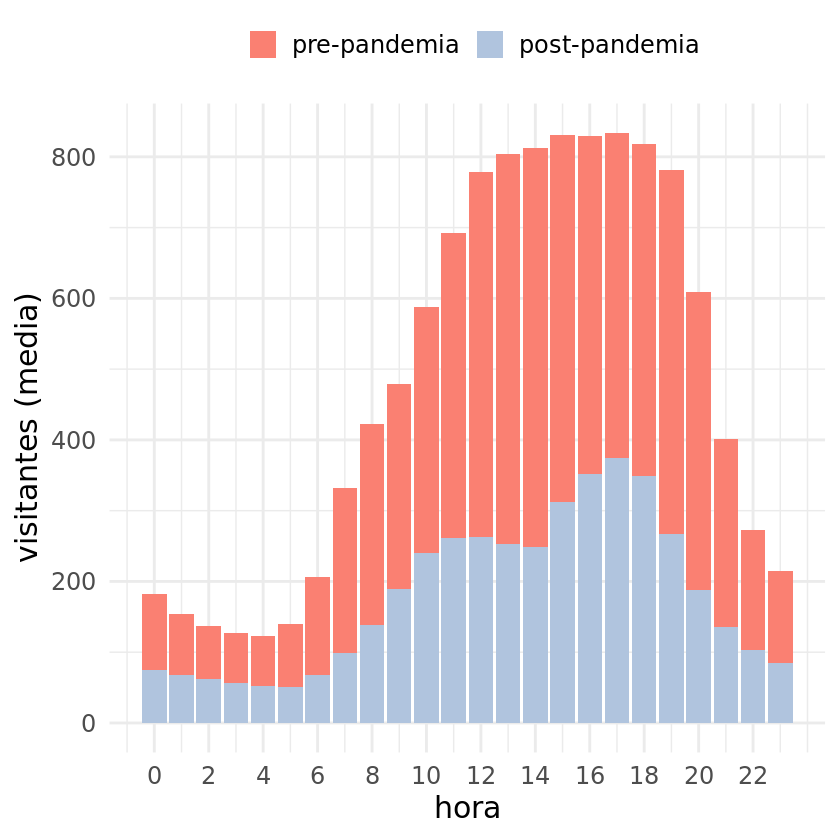

In [62]:
visitas_sitio %>%
    filter(!(h3idx_home %in% grilla_sitio$h3idx), month < 3) %>% 
    group_by(year, month, day, hour_of_day) %>% 
    summarise(visitantes = as.integer(sum(n))) %>% 
    group_by(hour_of_day) %>%
    summarise(media_visitantes = as.numeric(mean(visitantes)), 
              periodo = ordered("pre-pandemia", levels = c("pre-pandemia", "post-pandemia"))) %>%
    ggplot() +
    geom_col(aes(x = as.integer(hour_of_day), y = media_visitantes, fill = periodo)) +
    geom_col(data = visitas_sitio %>%
                        filter(!(h3idx_home %in% grilla_sitio$h3idx), month > 8) %>% 
                        group_by(year, month, day, hour_of_day) %>% 
                        summarise(visitantes = as.integer(sum(n))) %>% 
                        group_by(hour_of_day) %>%
                        summarise(media_visitantes = as.numeric(mean(visitantes)), 
                                  periodo = ordered("post-pandemia", levels = c("pre-pandemia", "post-pandemia"))),
            aes(x = as.integer(hour_of_day), y = media_visitantes, fill = periodo)) +
    scale_x_continuous(breaks = seq(0, 23, by = 2)) +
    scale_fill_manual(values = c("pre-pandemia" = "salmon", "post-pandemia" = "lightsteelblue"),  guide = guide_legend(reverse = TRUE)) +
    labs(x = "hora", y = "visitantes (media)", fill = NULL) +
    theme_minimal(base_size = 18) +
    theme(legend.position = "top")